# Tutorial 

This notebook demonstrates how to use our model by applying it to a toy dataset.

The input data are divided into three parts:
- **spikeTrain**: A list of spikes observed at each probe. Each spike is a 2D array with shape `(n, 1 + n_kappa)`, where `n` is the number of spikes and `n_kappa` is the dimension of the spike feature. The first column represents the spike time, and the remaining columns correspond to the spike features.
- **stim**: A covariate array with shape `(num_steps, 1 + n_y)`, where `num_steps` is the number of time steps, and `n_y` is the dimension of the covariate feature. The first column represents the time, and the remaining columns correspond to the covaraite values. 
- **sep**: An observation time interval $[T_1, T_2]$.

## 1. Generating toy data

Assume that there is $x_t$, which determines the firing rate of the neurons, defined as 
$$
x_t = \begin{bmatrix} \cos\left(\frac{2 \pi f t}{T}\right) \\ \sin\left(\frac{2 \pi f t}{T}\right) \end{bmatrix}, \quad t \in [0, T],
$$  
where $f = 5$ and $T = 100$.

Consider that there are three probes, and each probe measures the firing activities of five neurons. The joint mark intensity at probe $i$ is defined as  
$$
\lambda_{i}(x_t, \kappa) = \sum_{j=1}^5 \exp\left(\alpha + \beta \mu_{ij}^T x_t\right) \, \mathrm{N} \left(\kappa \mid \mu_{ij}, \sigma^2 I\right), \quad i = 1, \dots, 3,
$$  
where $ \mu_{ij} $ is the parameter of the $j$-th neuron at probe $i$, generated from a uniform distribution on the unit circle. The parameters $ \alpha $, $ \beta $, and $ \sigma $ are shared across probes.

The observed covariate $y_t$ is defined as  
$$
y_t = x_t.
$$


In [1]:
ROOTDIR = '/tf/workspace/MPPVAE' # Change this to the path of the repository
import os
os.chdir(ROOTDIR)
import numpy as np
np.set_printoptions(suppress = True)
import tensorflow as tf
from tqdm import tqdm
import time
from util import *
from model_JVAE import *

2025-01-03 11:29:52.724938: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-03 11:29:52.747619: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-hj74_cc1 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
T = 100
dt = 0.01
sep = [0, T]
num_steps = int(T / dt)

In [3]:
ts = np.linspace(0, T, num_steps)
ys = np.stack([np.cos(2 * np.pi * 5 * ts / T), np.sin(2 * np.pi * 5 * ts / T)]).T
stim = np.concatenate([ts[:, None], ys], axis=-1)

In [4]:
n_probes = 3
n_neurons = 5
mus = np.random.normal(0, 1, (n_probes, n_neurons, 2))
mus /= np.linalg.norm(mus, axis=-1, keepdims=True)

alpha, beta = 1., 1.
intensity_max = np.exp(alpha + beta)
ns = np.random.poisson(intensity_max * T, (n_probes, n_neurons))

spikeTrain = []

for i in range(n_probes):
    
    spikes_from_probe = []

    for j in range(n_neurons):
        tis = np.random.uniform(0, T, ns[i, j])
        xis = np.stack([np.cos(2 * np.pi * 5 * tis / T), np.sin(2 * np.pi * 5 * tis / T)]).T

        accept_ratio = np.exp(alpha + beta * (xis * mus[i, j]).sum(axis=-1)) / intensity_max
        mask = np.random.uniform(size=accept_ratio.shape) < accept_ratio

        tis = tis[mask]
        kappais = np.random.normal(mus[i, j], 0.1, (tis.shape[0], 2))
        spikes_from_neuron = np.concatenate([tis[:, None], kappais], axis=-1)
        
        spikes_from_probe.append(spikes_from_neuron)

    spikes_from_probe = np.concatenate(spikes_from_probe, axis=0)
    spikes_from_probe = spikes_from_probe[np.argsort(spikes_from_probe[:, 0])]
    spikeTrain.append(spikes_from_probe)


In [5]:
[spike.shape for spike in spikeTrain]

[(1702, 3), (1652, 3), (1748, 3)]

In [6]:
stim.shape

(10000, 3)

In [7]:
sep

[0, 100]

## 2. Training model

In [8]:
portion = [8, 1, 1]
perm = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

n_batch = 80
n_compile = 4
n_jackknife = 2
n_repeat = 10
learning_rate = 0.001
alpha_1, alpha_2 = 0., 2.

training_epochs = 200
eval_step = 50

n_monte = 10
n_monte_eval = 100

In [9]:
n_params = {'n_site': len(spikeTrain), 'n_y': stim.shape[1] - 1, 'n_kappa': [spike.shape[1] - 1 for spike in spikeTrain]}

n_params.update({'n_recog': [50, 50, 50, 50], 'n_recog_g': [50, 50, 50, 50], 'n_gener_x': [50, 50, 50, 50], 'n_gener_kappa': [50, 50, 50, 50],
                 'n_recog_y': [50, 50, 50, 50], 'n_gener_y': [50, 50, 50, 50], 'n_recog_kappa': [50, 50, 50, 50],
                 'n_z': 10, 'n_x': 10})

n_params.update({'n_batch': n_batch})
n_params.update({'alpha_1': alpha_1, 'alpha_2': alpha_2})
n_params.update({'learning_rate': learning_rate})
n_params.update({'n_compile': n_compile})
n_params.update({'n_jackknife': n_jackknife})

In [10]:
spikeTrain, stim, stim_mean, stim_cov = normalize(spikeTrain, stim, sep)

dataSet = makeDataSet(spikeTrain, stim)

trainDataSet, trainStimSet, trainSepSet, log_scale_train, valDataSet, valStimSet, valSepSet, log_scale_val, testDataSet, testStimSet, testSepSet, log_scale_test = splitDataSet(dataSet, stim, sep, portion, perm)

batch_ts_train, batch_inds_train, batch_kappas_train, batch_ttildes_train, batch_ys_train, batch_seps_train = splitDataBatch(trainDataSet, trainStimSet, trainSepSet, n_batch, n_params)
batch_ts_val, batch_inds_val, batch_kappas_val, batch_ttildes_val, batch_ys_val, batch_seps_val = splitDataBatch(valDataSet, valStimSet, valSepSet, 1, n_params)
batch_ts_test, batch_inds_test, batch_kappas_test, batch_ttildes_test, batch_ys_test, batch_seps_test = splitDataBatch(testDataSet, testStimSet, testSepSet, 1,  n_params)

batch_ts_padded_train, batch_kappas_padded_train, batch_masks_train, batch_ttildes_padded_train, batch_ys_padded_train = padDataBatch(batch_ts_train, batch_inds_train, batch_kappas_train, batch_ttildes_train, batch_ys_train)
batch_ts_padded_val, batch_kappas_padded_val, batch_masks_val, batch_ttildes_padded_val, batch_ys_padded_val = padDataBatch(batch_ts_val, batch_inds_val, batch_kappas_val, batch_ttildes_val, batch_ys_val)
batch_ts_padded_test, batch_kappas_padded_test, batch_masks_test, batch_ttildes_padded_test, batch_ys_padded_test = padDataBatch(batch_ts_test, batch_inds_test, batch_kappas_test, batch_ttildes_test, batch_ys_test)

del trainDataSet, trainStimSet, valDataSet, valStimSet, testDataSet, testStimSet, dataSet

2025-01-03 11:29:53.973485: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-03 11:29:53.976378: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-03 11:29:53.976461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [11]:
vae = JVAE(n_params)
vae.assign_log_lambda(batch_kappas_padded_train, batch_masks_train, batch_ys_padded_train, n_monte)

/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
2025-01-03 11:29:56.277378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [12]:
avg_cost = 0.

for epoch in tqdm(range(training_epochs)):

    shuffle_ind = tf.random.shuffle(tf.range(n_batch))
    batch_kappas_padded_train, batch_masks_train, batch_ys_padded_train = tf.gather(batch_kappas_padded_train, shuffle_ind), tf.gather(batch_masks_train, shuffle_ind), tf.gather(batch_ys_padded_train, shuffle_ind)
    avg_cost_epoch = vae.train(batch_kappas_padded_train, batch_masks_train, batch_ys_padded_train, n_monte)
    avg_cost += avg_cost_epoch

    if (epoch + 1) % eval_step == 0:

        avg_cost = avg_cost / eval_step
        print('Epoch:', '%04d' % (epoch + 1), '|', 'lambda_cost:', '{:.3f}'.format(avg_cost))
        avg_cost = 0.

  0%|                                                                                                                                                                                                         | 0/200 [00:00<?, ?it/s]2025-01-03 11:30:07.169632: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'fusion_218', 64 bytes spill stores, 64 bytes spill loads

2025-01-03 11:30:19.337481: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'fusion_218', 64 bytes spill stores, 64 bytes spill loads

2025-01-03 11:30:24.356414: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'fusion_218', 64 bytes spill stores, 64 bytes spill loads

2025-01-03 11:30:29.500526: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning :

Epoch: 0050 | lambda_cost: 159.206


 50%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 100/200 [01:52<01:20,  1.24it/s]

Epoch: 0100 | lambda_cost: -42.754


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 150/200 [02:32<00:40,  1.23it/s]

Epoch: 0150 | lambda_cost: -81.792


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:12<00:00,  1.04it/s]

Epoch: 0200 | lambda_cost: -123.683


## 3. Decoding covariate from spike trains

In [13]:
sep, kappas, masks, ttilde, y = batch_seps_test[0], batch_kappas_padded_test[0], batch_masks_test[0], batch_ttildes_padded_test[0], batch_ys_padded_test[0]
y_smoothed_means, y_smoothed_covs, x_smoothed_means, x_smoothed_covs = vae.decode(kappas, masks, log_scale_train, log_scale_test, n_monte_eval, 5, 100)
y, y_smoothed_means, y_smoothed_covs = denormalize(y, y_smoothed_means, y_smoothed_covs, stim_mean, stim_cov)

2025-01-03 11:33:12.903437: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x81401e0


The figure below shows the true and decoded covariates. The blue and orange solid lines represent each coordinate of the true covariate, while the blue and orange bands represent the two-sigma prediction intervals.

Text(0, 0.5, '$y$')

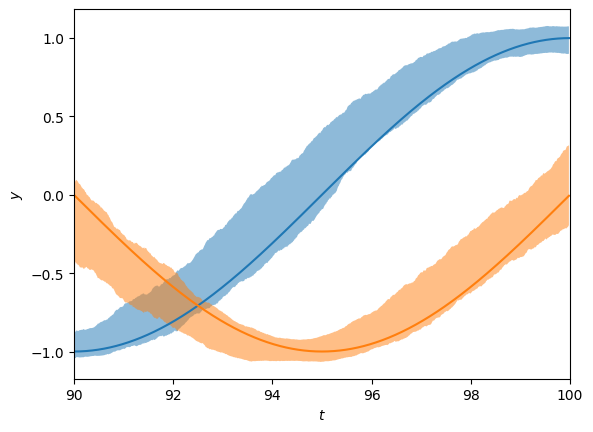

In [14]:
plt.plot(ttilde, y[:, 0, 0])
plt.fill_between(ttilde[:, 0], y_smoothed_means[:, 0, 0] - 2 * np.sqrt(y_smoothed_covs[:, 0, 0]), y_smoothed_means[:, 0, 0] + 2 * np.sqrt(y_smoothed_covs[:, 0, 0]), alpha=0.5)

plt.plot(ttilde, y[:, 0, 1])
plt.fill_between(ttilde[:, 0], y_smoothed_means[:, 0, 1] - 2 * np.sqrt(y_smoothed_covs[:, 1, 1]), y_smoothed_means[:, 0, 1] + 2 * np.sqrt(y_smoothed_covs[:, 1, 1]), alpha=0.5)

plt.xlim(sep[0], sep[1])

plt.xlabel(r'$t$')
plt.ylabel(r'$y$')